In [1]:
from __future__ import print_function, division
import os
import time
import torch
import torch.nn as nn
from  torch import optim 
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules.loss import BCEWithLogitsLoss
import cv2
from collections import OrderedDict
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision import transforms
from torchvision import models
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

In [2]:
final = pd.read_csv('mapping/final_dataset.csv')

In [3]:
final['banana'] = int(0)
final.loc[final['is_banana'] == True, 'banana'] = int(1)

In [4]:
final_small = final.sample(100)
final_small

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
4592,Nestor_Macias_RGB_5_3800_3800_7800_7800.png,3877.203125,3074.100098,3992.951172,3276.407959,0.213910,Nestor_Macias_RGB,5,3800,3800,...,Nestor_Macias_RGB,8929.312841,6778.334902,14.896868,fruit,0.0,97.044451,37.847336,72,0
2017,Carlos_Vera_Guevara_RGB_5_3800_3800_7800_7800.png,340.906097,2429.664307,503.628204,2574.322266,0.203243,Carlos_Vera_Guevara_RGB,5,3800,3800,...,Carlos_Vera_Guevara_RGB,5526.687059,5634.217919,10.345047,fruit,0.0,37.059003,14.453011,313,0
2733,Carlos_Vera_Arteaga_RGB_14_11297_7600_15297_11...,46.962524,1534.971436,240.853180,1711.576904,0.247210,Carlos_Vera_Arteaga_RGB,14,11297,7600,...,Carlos_Vera_Arteaga_RGB,8898.802413,6931.743274,7.957729,cacao,0.0,7.338873,2.862161,314,0
556,Flora_Pluas_RGB_17_11400_7600_15400_11600.png,340.046753,624.380066,902.301697,1174.010132,0.813819,Flora_Pluas_RGB,17,11400,7600,...,Flora_Pluas_RGB,10746.803491,7033.549456,13.941940,banana,0.0,8.213528,3.203276,219,1
2294,Carlos_Vera_Arteaga_RGB_9_7600_3800_11600_7800...,3050.874023,1503.561646,3295.818115,1723.682129,0.260833,Carlos_Vera_Arteaga_RGB,9,7600,3800,...,Carlos_Vera_Arteaga_RGB,9732.448365,4238.858785,7.957729,citrus,0.0,18.538871,7.230160,467,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1374,Nestor_Macias_RGB_5_3800_3800_7800_7800.png,3010.812988,1400.913940,3328.089600,1702.958618,0.372700,Nestor_Macias_RGB,5,3800,3800,...,Nestor_Macias_RGB,7401.652418,5982.739572,10.026738,banana,0.0,4.069971,1.587289,42,1
3768,Leonor_Aspiazu_RGB_6_3800_7600_7800_11600.png,1460.830200,1390.775391,1716.730835,1616.322876,0.243067,Leonor_Aspiazu_RGB,6,3800,7600,...,Leonor_Aspiazu_RGB,7447.144538,8337.394608,2.864782,fruit,0.0,1.249459,0.487289,268,0
3046,Flora_Pluas_RGB_7_3800_7600_7800_11600.png,15.364057,512.774048,433.949951,872.020874,0.371691,Flora_Pluas_RGB,7,3800,7600,...,Flora_Pluas_RGB,5943.129025,8212.374332,7.957729,cacao,0.0,7.338873,2.862161,369,0
3585,Leonor_Aspiazu_RGB_7_3800_9855_7800_13855.png,191.402466,2534.938477,483.701538,2777.671875,0.321536,Leonor_Aspiazu_RGB,7,3800,9855,...,Leonor_Aspiazu_RGB,6384.800771,11206.011033,3.342246,cacao,1.2,1.317234,0.513721,86,0


In [83]:
#train, trees_test = train_test_split(final, shuffle = True, random_state = 900, test_size = 0.2)

In [5]:
trees_train, trees_valid = train_test_split(final_small, shuffle = True, random_state = 900, test_size = 0.2)

In [6]:
trees_train

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
4267,Nestor_Macias_RGB_13_11003_3800_15003_7800.png,696.645569,2721.871094,945.755005,2939.187256,0.264209,Nestor_Macias_RGB,13,11003,3800,...,Nestor_Macias_RGB,10606.828973,6796.776882,7.547686,cacao,1.95,6.609039,2.577525,155,0
4363,Nestor_Macias_RGB_9_7600_3800_11600_7800.png,576.416382,139.688156,834.405273,382.064941,0.490172,Nestor_Macias_RGB,9,7600,3800,...,Nestor_Macias_RGB,8858.724029,5080.325805,6.843647,cacao,0.00,5.444228,2.123249,407,0
631,Flora_Pluas_RGB_7_3800_7600_7800_11600.png,1979.325439,1300.153931,2287.081787,1598.458984,0.652190,Flora_Pluas_RGB,7,3800,7600,...,Flora_Pluas_RGB,6281.812461,7336.339310,17.666157,banana,0.00,13.599844,5.303939,238,1
2503,Carlos_Vera_Arteaga_RGB_11_7600_11053_11600_15...,2599.111572,2384.379150,2841.707520,2612.137695,0.263618,Carlos_Vera_Arteaga_RGB,11,7600,11053,...,Carlos_Vera_Arteaga_RGB,7843.475329,10009.532443,7.957729,cacao,0.00,7.338873,2.862161,430,0
2735,Carlos_Vera_Arteaga_RGB_14_11297_7600_15297_11...,256.270340,1259.878296,442.810913,1412.549683,0.237990,Carlos_Vera_Arteaga_RGB,14,11297,7600,...,Carlos_Vera_Arteaga_RGB,9357.022376,6424.515776,6.047874,fruit,0.00,8.983202,3.503449,366,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4504,Nestor_Macias_RGB_7_3800_9024_7800_13024.png,729.933960,1770.743652,951.141724,2001.001709,0.242960,Nestor_Macias_RGB,7,3800,9024,...,Nestor_Macias_RGB,6838.000224,9424.551898,6.843647,cacao,0.00,5.444228,2.123249,58,0
2811,Flora_Pluas_RGB_8_3800_11400_7800_15400.png,648.905151,2488.760254,980.387329,2861.750977,0.423027,Flora_Pluas_RGB,8,3800,11400,...,Flora_Pluas_RGB,6415.162118,11000.304403,4.906919,cacao,1.80,2.817530,1.098837,290,0
2125,Carlos_Vera_Guevara_RGB_1_0_3800_4000_7800.png,2633.289307,1269.830444,2767.817383,1402.552490,0.333307,Carlos_Vera_Guevara_RGB,1,0,3800,...,Carlos_Vera_Guevara_RGB,4652.828501,5111.095507,9.230965,fruit,0.00,27.431678,10.698354,312,0
539,Flora_Pluas_RGB_9_3800_11578_7800_15578.png,754.690063,3351.869385,1096.852905,3695.206543,0.533173,Flora_Pluas_RGB,9,3800,11578,...,Flora_Pluas_RGB,5499.988358,11973.458521,22.313471,banana,0.00,22.365017,8.722357,24,1


In [7]:
# make the training set
trees_train.to_csv('mapping/train_small.csv', index = False) 

In [8]:
# make the validation set
trees_valid.to_csv('mapping/valid_small.csv', index = False) 

In [88]:
# make the test set
#trees_test.to_csv('mapping/test.csv', index = False) 

In [9]:
trees_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80 entries, 4267 to 3880
Data columns (total 44 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   img_path          80 non-null     object 
 1   xmin              80 non-null     float64
 2   ymin              80 non-null     float64
 3   xmax              80 non-null     float64
 4   ymax              80 non-null     float64
 5   score             80 non-null     float64
 6   img_name          80 non-null     object 
 7   tile_index        80 non-null     int64  
 8   tile_xmin         80 non-null     int64  
 9   tile_ymin         80 non-null     int64  
 10  tile_xmax         80 non-null     int64  
 11  tile_ymax         80 non-null     int64  
 12  x                 80 non-null     float64
 13  y                 80 non-null     float64
 14  Xmin              80 non-null     float64
 15  Ymin              80 non-null     float64
 16  Xmax              80 non-null     float64

In [175]:
trees_train['group'].value_counts()

cacao     38
banana    23
fruit     15
other      2
citrus     2
Name: group, dtype: int64

In [176]:
trees_train['site'].value_counts()

Flora_Pluas_RGB            19
Carlos_Vera_Arteaga_RGB    14
Carlos_Vera_Guevara_RGB    14
Nestor_Macias_RGB          14
Leonor_Aspiazu_RGB         12
Manuel_Macias_RGB           7
Name: site, dtype: int64

In [177]:
trees_valid['group'].value_counts()

cacao     10
fruit      4
banana     3
other      2
timber     1
Name: group, dtype: int64

In [178]:
trees_valid['site'].value_counts()

Carlos_Vera_Guevara_RGB    6
Carlos_Vera_Arteaga_RGB    5
Manuel_Macias_RGB          4
Leonor_Aspiazu_RGB         2
Nestor_Macias_RGB          2
Flora_Pluas_RGB            1
Name: site, dtype: int64

<Axes: >

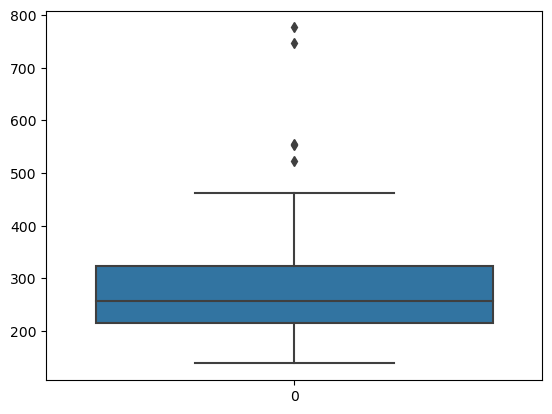

In [179]:
h = trees_train['ymax'].values - trees_train['ymin'].values

# Boxplot of bbox heights
sns.boxplot(h)

<Axes: >

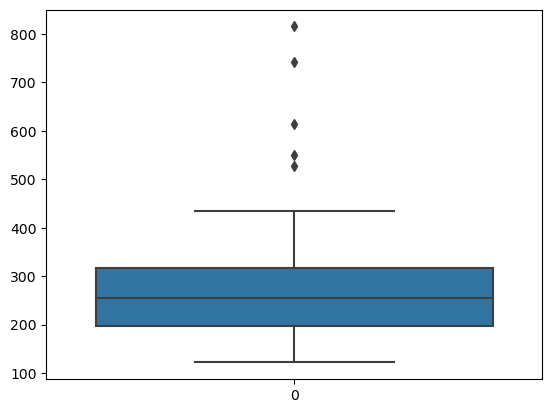

In [180]:
w = trees_train['xmax'].values - trees_train['xmin'].values

# Boxplot of bbox widths
sns.boxplot(w)

<Axes: >

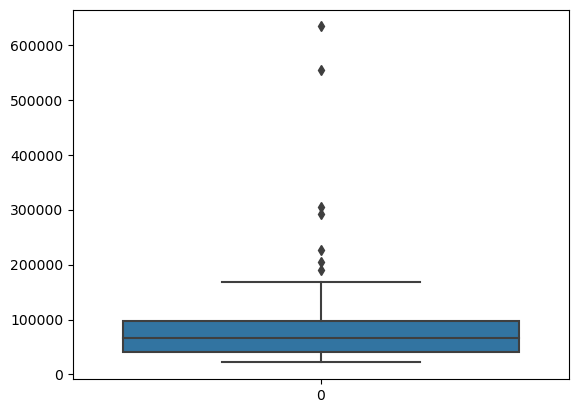

In [181]:
area = h * w

# Boxplot of bbox widths
sns.boxplot(area)
# Area can vary by 2 orders of magnitude, 
#we need to resize the images to be of similar sizes

In [182]:
trees_train.loc[trees_train['ymax'] - trees_train['ymin'] > 800]

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana


In [183]:
trees_train.loc[trees_train['group']=='banana']

,img_path,xmin,ymin,xmax,ymax,score,img_name,tile_index,tile_xmin,tile_ymin,...,site,X_g,Y_g,updated diameter,group,updated height,AGB,carbon,id,banana
571,Flora_Pluas_RGB_17_11400_7600_15400_11600.png,924.334717,3290.504639,1128.983643,3482.032715,0.221704,Flora_Pluas_RGB,17,11400,7600,...,Flora_Pluas_RGB,11187.845136,8005.086847,10.345047,banana,0.0,4.350122,1.696548,55,1
467,Flora_Pluas_RGB_8_3800_11400_7800_15400.png,661.942383,853.592468,979.764771,1205.268799,0.525384,Flora_Pluas_RGB,8,3800,11400,...,Flora_Pluas_RGB,6172.416353,8549.115451,20.212631,banana,0.0,18.117484,7.065819,366,1
840,Leonor_Aspiazu_RGB_11_7600_9855_11600_13855.png,1085.132690,2410.567383,1427.199829,2873.591553,0.535793,Leonor_Aspiazu_RGB,11,7600,9855,...,Leonor_Aspiazu_RGB,8675.161021,9622.086446,9.230965,banana,0.0,3.412696,1.330951,77,1
863,Leonor_Aspiazu_RGB_9_7600_3800_11600_7800.png,2377.293213,3392.279541,2682.093750,3695.184570,0.662435,Leonor_Aspiazu_RGB,9,7600,3800,...,Leonor_Aspiazu_RGB,10699.881117,6584.715438,10.663356,banana,0.0,4.640185,1.809672,13,1
1492,Nestor_Macias_RGB_10_7600_7600_11600_11600.png,584.844055,1422.186523,884.488953,1745.024292,0.463752,Nestor_Macias_RGB,10,7600,7600,...,Nestor_Macias_RGB,8379.418587,7897.804564,13.146168,banana,0.0,7.247087,2.826364,334,1
353,Carlos_Vera_Arteaga_RGB_13_11297_3800_15297_78...,848.217407,3021.010742,1016.843384,3169.133057,0.233488,Carlos_Vera_Arteaga_RGB,13,11297,3800,...,Carlos_Vera_Arteaga_RGB,10134.682806,5238.274090,11.777438,banana,0.0,5.734024,2.236270,179,1
671,Flora_Pluas_RGB_14_7600_11578_11600_15578.png,2775.933105,1500.548828,3191.093994,1905.749390,0.477064,Flora_Pluas_RGB,14,7600,11578,...,Flora_Pluas_RGB,10348.853541,9067.622866,14.069264,banana,0.0,8.374122,3.265908,34,1
669,Flora_Pluas_RGB_14_7600_11578_11600_15578.png,1828.736816,2181.609863,2155.052490,2510.582275,0.526606,Flora_Pluas_RGB,14,7600,11578,...,Flora_Pluas_RGB,9855.336336,9888.573694,14.483066,banana,0.0,8.907465,3.473911,417,1
1248,Nestor_Macias_RGB_7_3800_9024_7800_13024.png,1963.933228,1275.976196,2159.486084,1496.312988,0.481546,Nestor_Macias_RGB,7,3800,9024,...,Nestor_Macias_RGB,6835.989448,8566.067343,11.299975,banana,0.0,5.250205,2.047580,189,1
636,Flora_Pluas_RGB_7_3800_7600_7800_11600.png,1395.391724,601.760803,1711.384277,923.333557,0.615846,Flora_Pluas_RGB,7,3800,7600,...,Flora_Pluas_RGB,6373.552086,6842.313759,15.915457,banana,0.0,10.889200,4.246788,159,1


In [10]:
n = 10
img_name = trees_train.iloc[n, 0]
print(img_name)

Leonor_Aspiazu_RGB_9_7600_3800_11600_7800.png


In [11]:
df_img1 = trees_train.loc[trees_train['img_path'] == img_name]
tile1 = io.imread(os.path.join('tiles/all_tiles/', img_name))

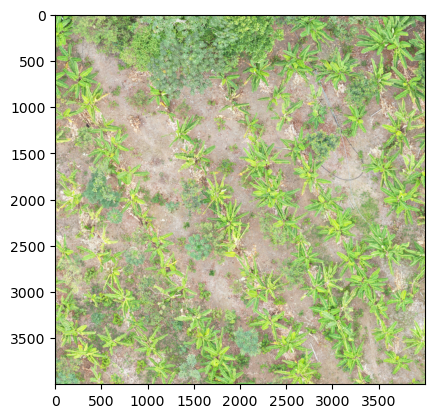

In [12]:
plt.imshow(tile1)
plt.show()

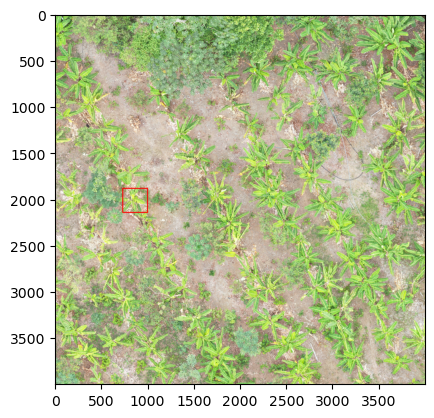

In [13]:
i = 0
for name in df_img1['img_path'].values:
    
    xmin = round(df_img1['xmin'].values[i])
    ymin = round(df_img1['ymin'].values[i])
    xmax = round(df_img1['xmax'].values[i])
    ymax = round(df_img1['ymax'].values[i])

    color = (255,0,0)
    
    tile1 = cv2.rectangle(tile1,(xmin,ymin),(xmax,ymax),color,10)
    
    i += 1
    #break

plt.imshow(tile1)   

In [187]:
def center_crop(img, dim):
	"""Returns center cropped image
	Args:
	img: image to be center cropped
	dim: dimensions (width, height) to be cropped
	"""
	width, height = img.shape[1], img.shape[0]

	# process crop width and height for max available dimension
	crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
	crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
	mid_x, mid_y = int(width/2), int(height/2)
	cw2, ch2 = int(crop_width/2), int(crop_height/2) 
	crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
	return crop_img

In [188]:
preprocess = transforms.Compose([
                     
                     #transforms.RandomResizedCrop(224),
                     transforms.ToTensor(),
                     transforms.Resize(224)
                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                ])

In [189]:
class Trees(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.trees_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.trees_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.trees_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        xmin = self.trees_frame.iloc[idx]['xmin']
        ymin = self.trees_frame.iloc[idx]['ymin']
        xmax = self.trees_frame.iloc[idx]['xmax']
        ymax = self.trees_frame.iloc[idx]['ymax']
        
        image = image[round(ymin):round(ymax)+1, round(xmin):round(xmax)+1]
        image = center_crop(image, [800, 800])
        
        border_height = round((800 - image.shape[0]) / 2)
        border_width  = round((800 - image.shape[1]) / 2)
        
        image = cv2.copyMakeBorder(image, border_height, border_height, border_width, border_width, cv2.BORDER_CONSTANT, None, value = 0)
        
        is_banana = self.trees_frame.iloc[idx]['banana']
        
        #image = Image.fromarray(image)
        
        #image = transforms.Resize(224)
        image = preprocess(image)

        
        sample = image, int(is_banana)

        if self.transform:
            sample = self.transform(sample)

        return sample

In [190]:
ttrain = Trees(csv_file='mapping/train_small.csv', root_dir='tiles/all_tiles')

In [191]:
imgs = torch.stack([img_t for img_t, _ in ttrain], dim=3)

In [192]:
imgs.view(3, -1).mean(dim=1)

tensor([0.0893, 0.0985, 0.0722])

In [193]:
imgs.view(3, -1).std(dim=1)

tensor([0.2281, 0.2495, 0.1898])

In [194]:
tvalid = Trees(csv_file='mapping/valid_small.csv', root_dir='tiles/all_tiles')

(array([9.42491214, 0.01562406, 0.03305089, 0.04032876, 0.05715467,
        0.07598366, 0.09240893, 0.13480761, 0.14195195, 0.03445304]),
 array([0.        , 0.0994958 , 0.1989916 , 0.2984874 , 0.39798319,
        0.49747899, 0.59697479, 0.69647062, 0.79596639, 0.89546216,
        0.99495798]),
 <BarContainer object of 10 artists>)

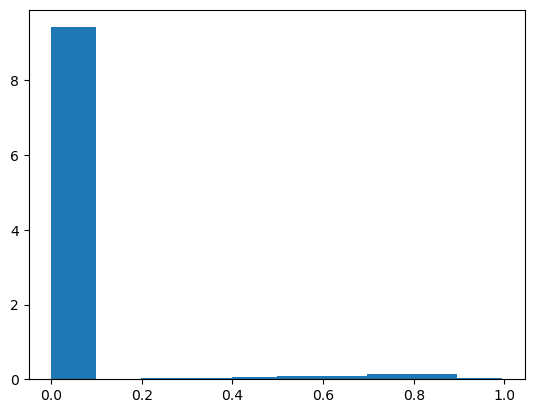

In [195]:
plt.hist(ttrain[0][0].ravel(), density=True)

(array([9.48903945e+00, 9.45957962e-04, 1.06758105e-02, 4.47303013e-02,
        1.03852678e-01, 1.69596710e-01, 1.70745477e-01, 1.08244594e-01,
        6.35819128e-02, 9.52714588e-03]),
 array([0.        , 0.09831933, 0.19663866, 0.294958  , 0.39327732,
        0.49159664, 0.58991599, 0.68823528, 0.78655463, 0.88487393,
        0.98319328]),
 <BarContainer object of 10 artists>)

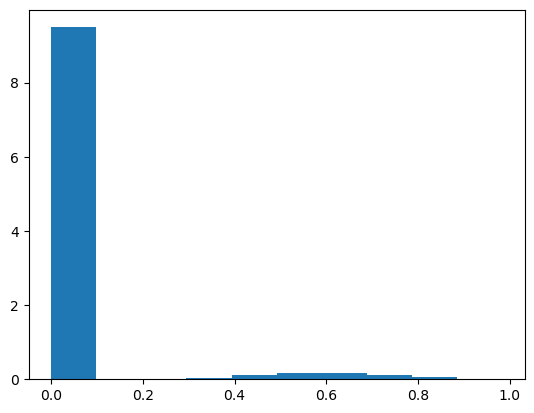

In [196]:
plt.hist(tvalid[0][0].ravel(), density=True)

is_banana: 1


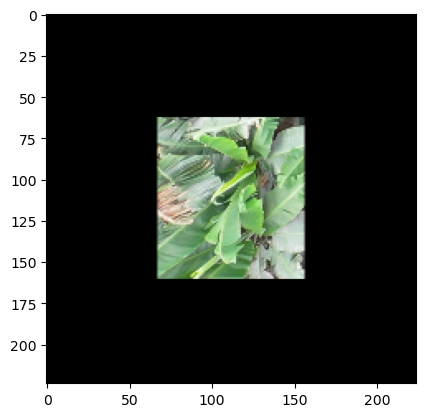

In [197]:
im, label = ttrain[1]
plt.imshow(im.permute(1,2,0))
print('is_banana:',label)

is_banana: 0


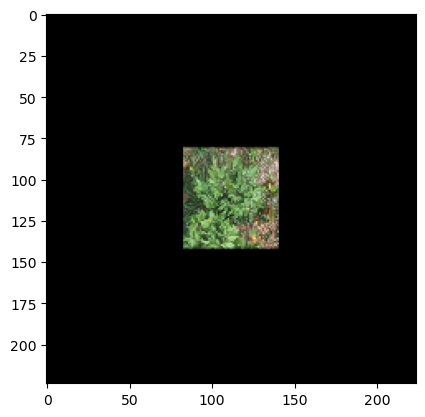

In [198]:
im, label = ttrain[3]
plt.imshow(im.permute(1,2,0))
print('is_banana:',label)

In [199]:
for i in range(len(ttrain)):
    sample = ttrain[i]

    print(i, sample[0].shape, sample[1])

    if i == 3:
        break

0 torch.Size([3, 224, 224]) 1
1 torch.Size([3, 224, 224]) 1
2 torch.Size([3, 224, 224]) 1
3 torch.Size([3, 224, 224]) 0


In [ ]:
# Wrap it onto a dataloader

In [200]:
train_dataloader = DataLoader(ttrain, batch_size=16, shuffle=True)

In [201]:
valid_dataloader = DataLoader(tvalid, batch_size=16, shuffle=False)

In [202]:
print(len(train_dataloader), len(valid_dataloader))

5 2


In [203]:
print('Train dataset size:', len(ttrain))

Train dataset size: 80


In [204]:
model = models.resnet18(pretrained=True)

In [205]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Below, we train resnet18 for with our images

In [66]:
#def set_parameter_requires_grad(model, feature_extracting=True):
#    if feature_extracting:
#        for param in model.parameters():
#            param.requires_grad = False
            
#set_parameter_requires_grad(resnet18, False)

In [206]:
modelOutputFeats = model.fc.in_features
modelOutputFeats

512

In [207]:
# Initialize new final output layer
model.fc = nn.Linear(modelOutputFeats, 1)

#fc = nn.Sequential(OrderedDict([
#    ('fc1', nn.Linear(512,100)),
#    ('relu', nn.ReLU()),
#    ('fc2', nn.Linear(100,2)),
#    ('output', nn.LogSoftmax(dim=1))
#]))

#model.fc = fc

In [208]:
# Check which layer in the model that will compute the gradient
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [209]:
# Here we only want to update the gradient for the classifier layer that we initialized.
params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            
#optimizer = optim.Adam(params_to_update)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [210]:
optimizer = torch.optim.Adam(model.fc.parameters())

In [211]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup the loss function
criterion = BCEWithLogitsLoss()

In [212]:
device

device(type='cuda')

In [215]:
train_loss = []
val_loss = []

epochs = 20

if torch.cuda.is_available():
    model.cuda()

for epoch in range(epochs):
      print("epoch {}/{}".format(epoch+1,epochs))
      running_loss = 0.0
      running_score = 0.0
#       model.train()
      for image,label in train_dataloader:
          image, label = image.to(device), label.to(device)
          label = label.unsqueeze(1)
          optimizer.zero_grad()
          y_pred = model(image)
          #print(y_pred)
          loss = criterion(y_pred,label.float())         
          loss.backward() #calculate derivatives 
          optimizer.step() # update parameters
          val, index_ = torch.max(y_pred,axis=1)
          #print(label.data, y_pred)
          running_score += torch.sum(index_ == label.data).item()
          running_loss += loss.item()
      
      epoch_score = running_score/len(train_dataloader.dataset)
      epoch_loss = running_loss/len(train_dataloader.dataset)
      train_loss.append(epoch_loss)
     # print("Training loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
      print("Training loss: {}".format(epoch_loss))
      
      with torch.no_grad():
          model.eval()
          running_loss = 0.0
          running_score = 0.0
          for image,label in valid_dataloader:
                image = image.to(device)
                label = label.to(device)
                label = label.unsqueeze(1)
                optimizer.zero_grad()
                y_pred = model(image)
                loss = criterion(y_pred,label.float())
                running_loss += loss.item()

                val, index_ = torch.max(y_pred,axis=1)
                running_score += torch.sum(index_ == label.data).item()
          
          epoch_score = running_score/len(valid_dataloader.dataset)
          epoch_loss = running_loss/len(valid_dataloader.dataset)
          val_loss.append(epoch_loss)
          #print("Validation loss: {}, accuracy: {}".format(epoch_loss,epoch_score))
          print("Validation loss: {}".format(epoch_loss))


epoch 1/20
Training loss: 0.02968173138797283
Validation loss: 0.036046364903450014
epoch 2/20
Training loss: 0.02773287519812584
Validation loss: 0.032319276034832
epoch 3/20
Training loss: 0.025956736132502555
Validation loss: 0.030125167220830917
epoch 4/20
Training loss: 0.02444390133023262
Validation loss: 0.029234392940998076
epoch 5/20
Training loss: 0.023081707209348677
Validation loss: 0.028028671443462373
epoch 6/20
Training loss: 0.02180970199406147
Validation loss: 0.026841079443693162
epoch 7/20
Training loss: 0.02076576612889767
Validation loss: 0.025383567810058592
epoch 8/20
Training loss: 0.019932355359196664
Validation loss: 0.024288439005613328
epoch 9/20
Training loss: 0.018961546197533607
Validation loss: 0.0229263961315155
epoch 10/20
Training loss: 0.018280174024403094
Validation loss: 0.021873752772808074
epoch 11/20
Training loss: 0.017691098526120184
Validation loss: 0.020986860245466234
epoch 12/20
Training loss: 0.017014141380786895
Validation loss: 0.020500

In [216]:
epochs = range(1, 21)

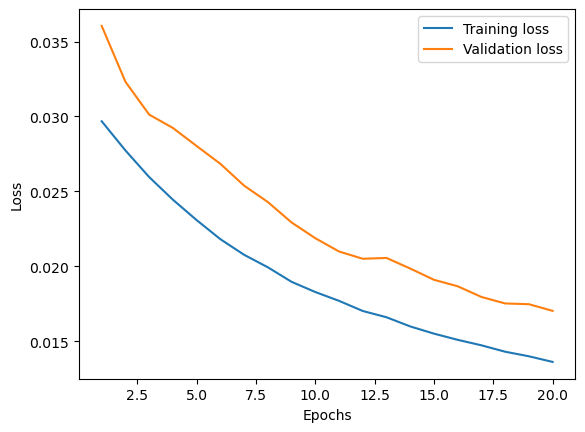

In [220]:
plt.plot(epochs, train_loss, label = 'Training loss')
plt.plot(epochs, val_loss, label = 'Validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()